Monte Carlo Simulation: I reorganized the pixels in a source image S, to look like a target image T. This creates a new image S’ with different colors and looks exactly like the target image T. Monte Carlo algorith: Metropolis single pixel updates
![Project obejective:](images/collage.png)
![Project obejective:](images/collage2.png)

In [1]:
import os
import sys
import scipy.io
import scipy.misc
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image
import PIL
from nst_utils import *
import numpy as np
import tensorflow as tf

%matplotlib inline

![Project obejective:](images/pic1.png)

In [2]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")
print(model)

{'input': <tf.Variable 'Variable:0' shape=(1, 300, 400, 3) dtype=float32_ref>, 'conv1_1': <tf.Tensor 'Relu:0' shape=(1, 300, 400, 64) dtype=float32>, 'conv1_2': <tf.Tensor 'Relu_1:0' shape=(1, 300, 400, 64) dtype=float32>, 'avgpool1': <tf.Tensor 'AvgPool:0' shape=(1, 150, 200, 64) dtype=float32>, 'conv2_1': <tf.Tensor 'Relu_2:0' shape=(1, 150, 200, 128) dtype=float32>, 'conv2_2': <tf.Tensor 'Relu_3:0' shape=(1, 150, 200, 128) dtype=float32>, 'avgpool2': <tf.Tensor 'AvgPool_1:0' shape=(1, 75, 100, 128) dtype=float32>, 'conv3_1': <tf.Tensor 'Relu_4:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_2': <tf.Tensor 'Relu_5:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_3': <tf.Tensor 'Relu_6:0' shape=(1, 75, 100, 256) dtype=float32>, 'conv3_4': <tf.Tensor 'Relu_7:0' shape=(1, 75, 100, 256) dtype=float32>, 'avgpool3': <tf.Tensor 'AvgPool_2:0' shape=(1, 38, 50, 256) dtype=float32>, 'conv4_1': <tf.Tensor 'Relu_8:0' shape=(1, 38, 50, 512) dtype=float32>, 'conv4_2': <tf.Tensor 'Relu_9:0' shap

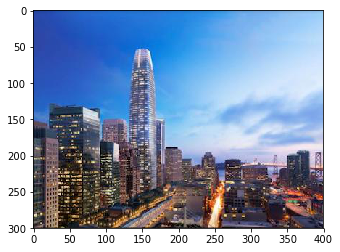

In [3]:
content_image = scipy.misc.imread("images/Con5.jpg")
imshow(content_image)

![Project obejective:](images/pic2.png)

In [4]:
def compute_content_cost(a_C, a_G):
    """
   
    Arguments:
    a_C -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image C 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing content of the image G
    
    Returns: 
    J_content -- scalar
    """
    
    
    # dimensions from a_G
    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    
    # Reshape a_C and a_G
    a_C_unrolled = tf.transpose(a_C)
    a_G_unrolled = tf.transpose(a_G)
    
   
    J_content = (1/ (4* n_H * n_W * n_C)) * tf.reduce_sum(tf.pow((a_G_unrolled - a_C_unrolled), 2))
    
    
    return J_content

In [5]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_C = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_content = compute_content_cost(a_C, a_G)
    print("J_content = " + str(J_content.eval()))

J_content = 6.76559


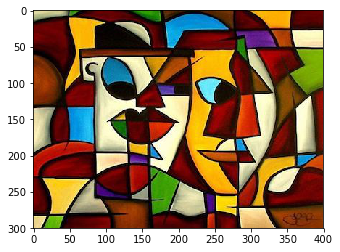

In [4]:
style_image = scipy.misc.imread("images/Sty6.jpg")
imshow(style_image)

![Project obejective:](images/pic3.png)

In [7]:
def gram_matrix(A):
    """
   
    A -- matrix of shape (n_C, n_H*n_W)
    
    GA -- Gram matrix of A, of shape (n_C, n_C)
    """
    
    
    GA = tf.matmul(A, tf.transpose(A))
   
    
    return GA

In [8]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    A = tf.random_normal([3, 2*1], mean=1, stddev=4)
    GA = gram_matrix(A)
    
    print("GA = " + str(GA.eval()))

GA = [[  6.42230511  -4.42912197  -2.09668207]
 [ -4.42912197  19.46583748  19.56387138]
 [ -2.09668207  19.56387138  20.6864624 ]]


In [9]:
def compute_layer_style_cost(a_S, a_G):
    """
  
    a_S -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image S 
    a_G -- tensor of dimension (1, n_H, n_W, n_C), hidden layer activations representing style of the image G
    
    J_style_layer: style cost for one layer
    """

    m, n_H, n_W, n_C = a_G.get_shape().as_list()
    

    a_S = tf.transpose(tf.reshape(a_S, [n_H*n_W, n_C]))
    a_G = tf.transpose(tf.reshape(a_G, [n_H*n_W, n_C]))

    # gram_matrices for both images S and G 
    GS = gram_matrix(a_S)
    GG = gram_matrix(a_G)

    #style loss
    J_style_layer = (1./(4 * n_C**2 * (n_H*n_W)**2)) * tf.reduce_sum(tf.pow((GS - GG), 2))
    
   
    
    return J_style_layer

In [10]:
tf.reset_default_graph()

with tf.Session() as test:
    tf.set_random_seed(1)
    a_S = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    a_G = tf.random_normal([1, 4, 4, 3], mean=1, stddev=4)
    J_style_layer = compute_layer_style_cost(a_S, a_G)
    
    print("J_style_layer = " + str(J_style_layer.eval()))

J_style_layer = 9.19028


In [11]:
STYLE_LAYERS = [
    ('conv1_1', 0.2),
    ('conv2_1', 0.2),
    ('conv3_1', 0.2),
    ('conv4_1', 0.2),
    ('conv5_1', 0.2)]

In [12]:
def compute_style_cost(model, STYLE_LAYERS):
    """
    model -- our tensorflow model
    STYLE_LAYERS -- A python list containing the names of the layers we would like to extract style from
    
    J_style -- tensor representing a scalar value
    """
    
    J_style = 0

    for layer_name, coeff in STYLE_LAYERS:

        # output tensor of the currently selected layer
        out = model[layer_name]

        # Setting a_S to be the hidden layer activation
        a_S = sess.run(out)

        # Setting a_G to be the hidden layer activation to be evaluated later
        a_G = out
        
        # Compute style_cost for the current layer
        J_style_layer = compute_layer_style_cost(a_S, a_G)

        # Add coeff * J_style_layer of this layer to overall style cost
        J_style += coeff * J_style_layer

    return J_style

In [13]:
def total_cost(J_content, J_style, alpha = 10, beta = 40):
   
   
    J = alpha * J_content + beta * J_style
   
    
    return J

In [14]:
tf.reset_default_graph()

with tf.Session() as test:
    np.random.seed(3)
    J_content = np.random.randn()    
    J_style = np.random.randn()
    J = total_cost(J_content, J_style)
    print("J = " + str(J))

J = 35.34667875478276


In [15]:
# Reset the graph
tf.reset_default_graph()

# Start interactive session
sess = tf.InteractiveSession()

In [16]:
content_image = scipy.misc.imread("images/Con5.jpg")
content_image = reshape_and_normalize_image(content_image)

In [ ]:
style_image = scipy.misc.imread("images/Sty6.jpg")
style_image = reshape_and_normalize_image(style_image)

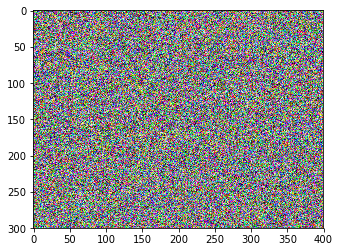

In [18]:
generated_image = generate_noise_image(content_image)
imshow(generated_image[0])

In [19]:
model = load_vgg_model("pretrained-model/imagenet-vgg-verydeep-19.mat")

In [20]:
# content image to be the input of the VGG model.  
sess.run(model['input'].assign(content_image))

# output tensor of layer conv4_2
out = model['conv4_2']

# a_C hidden layer activation
a_C = sess.run(out)

# Set a_G to be the hidden layer activation from same layer. a_G will be evaluated later.
a_G = out

#content cost
J_content = compute_content_cost(a_C, a_G)

In [21]:
# input of the model to be the "style" image 
sess.run(model['input'].assign(style_image))

#style cost
J_style = compute_style_cost(model, STYLE_LAYERS)

In [22]:
J = total_cost(J_content, J_style, alpha = 10, beta = 40)

In [23]:
# optimizer
optimizer = tf.train.AdamOptimizer(2.0)

# train_step
train_step = optimizer.minimize(J)

In [24]:
def model_nn(sess, input_image, num_iterations = 160):
    rows=1
    # Initializing global variables
   
    sess.run(tf.global_variables_initializer())
   
    sess.run(model['input'].assign(input_image))
   
    
    for i in range(num_iterations):
    
        #session on train_step to minimize the total cost
       
        sess.run(train_step)
        
        
      #generated image by running the session on the current model['input']
        
        generated_image = sess.run(model['input'])
       
        
        # Printing every 20 iteration.
        if i%20 == 0:
            Jt, Jc, Js = sess.run([J, J_content, J_style])
            print("Iteration " + str(i) + " :")
            print("total cost = " + str(Jt))
            print("content cost = " + str(Jc))
            print("style cost = " + str(Js))
            
            
            save_image("output/" + str(i) + ".png", generated_image)
            img_g = PIL.Image.open("output/" + str(i) + ".png")
            plt.imshow(img_g)
            plt.show()
            
    
    # final generated image
    save_image('output/generated_image.jpg', generated_image)
    
    return generated_image

Iteration 0 :
total cost = 7.21982e+10
content cost = 10632.9
style cost = 1.80495e+09


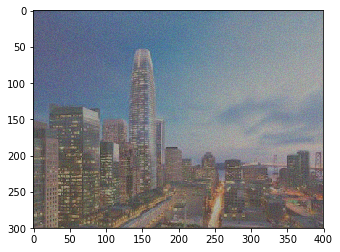

Iteration 20 :
total cost = 2.45146e+10
content cost = 25678.1
style cost = 6.12859e+08


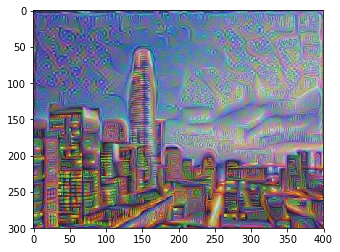

Iteration 40 :
total cost = 1.03161e+10
content cost = 35685.5
style cost = 2.57893e+08


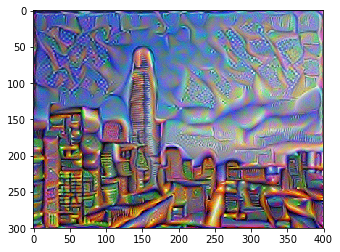

Iteration 60 :
total cost = 5.849e+09
content cost = 38966.9
style cost = 1.46215e+08


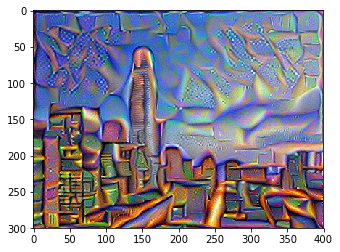

Iteration 80 :
total cost = 4.04207e+09
content cost = 40582.9
style cost = 1.01042e+08


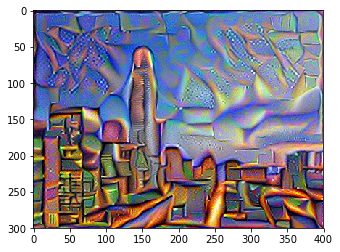

Iteration 100 :
total cost = 3.08353e+09
content cost = 41572.3
style cost = 7.70778e+07


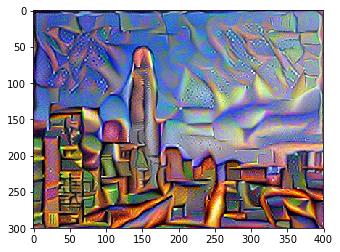

Iteration 120 :
total cost = 2.48654e+09
content cost = 42399.1
style cost = 6.2153e+07


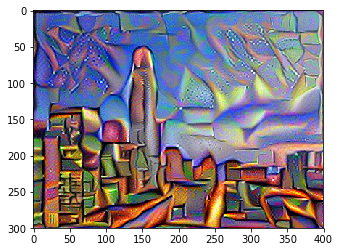

Iteration 140 :
total cost = 2.07493e+09
content cost = 43063.0
style cost = 5.18624e+07


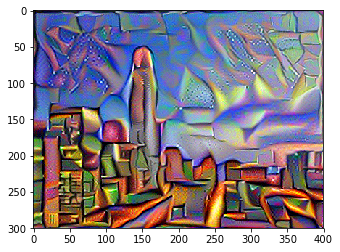

array([[[[   0.28420746,    1.30868566,   56.62563324],
         [   8.89900684, -123.41811371,   -2.32913613],
         [-119.40996552, -112.07601166, -113.05706787],
         ..., 
         [  39.10132599,  -10.07656384,    9.04990768],
         [  39.46668625,   -6.72856712,    0.67715746],
         [  10.40085411,  -14.79186535,   19.39102936]],

        [[  22.0115757 ,   -8.34408951,   50.55601883],
         [ -44.46225357,  -66.23271179,  -49.44903946],
         [ -89.3197937 ,  -90.19010162,  -71.90627289],
         ..., 
         [  38.62711334,   -0.19738638,  -33.68153381],
         [  68.64003754,   -8.19704247,  -45.55238724],
         [  29.06926727,   -1.63842511,    3.14299655]],

        [[  21.05765724,  -11.95833492,   55.6360321 ],
         [ -57.09379959,  -72.20897675,  -47.38252258],
         [ -98.7804718 ,  -82.20085907,  -79.20796967],
         ..., 
         [  48.97812271,  -65.2342453 ,   62.83436584],
         [  43.22314072,  -48.54047394,   53.51251984],

In [25]:
model_nn(sess, generated_image)

![Project obejective:](images/Con5.jpg)
![Project obejective:](images/Sty6.jpg)
![Project obejective:](images/sf_nst.jpg)


